In [4]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa, cpw_kinetic_inductance, penetration_depth
from modeling.utils.network import assemble_network
from modeling.utils.qubits import *
from qucat import Network,L,J,C,R
from modeling.clockmon.libraries.clockmon_library import clockmon_coupling_libraries, clockmon_library, clockmon_cqr_to_ground
from modeling.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_library, digit_tee_ck_to_ground, get_ck
import scqubits as scq
from scqubits import ParameterSweep

In [3]:
smooth_capacitor_lib = digit_tee_library(deembed = [300, 200])
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])
clockmon_lib = clockmon_library(deembed = 200) 
cqr_to_ground = clockmon_cqr_to_ground(deembed = 200)

In [8]:
planck_h = 6.62607015e-34
e_charge = 1.60217663e-19
phi0 =  2.067833848e-15 # Wb

a = 10e-6
b = 6e-6
ep_r = 11.45

nb_qubits = 6
rr_freq_target = np.array([7.0e9, 7.1e9, 7.2e9, 7.3e9, 7.4e9, 7.5e9])
qubit_freq_target = np.array([5e9, 5.1e9, 5.2e9, 5.3e9, 5.4e9, 5.5e9])
c_sigma = 90e-15
kappa_target = 0.8e6
target_parameters = {
    "chi": 0.4e6,
    "qubit_frequency": qubit_freq_target,
    "rr_frequencies_target": rr_freq_target,
    "c_sigma_unloaded": c_sigma
}
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real
l_r = Z0*pi/(4*pi*rr_freq_target)
c_r = 1/((2*pi*rr_freq_target)**2*l_r)

In [9]:
def minimize_func(x, c_r = None, l_r = None, target_qubit_frequency = None):
    cir = Network([
        C(0,1,c_sigma - x[0]*1e-15), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r - x[0]*1e-15), # resonator
        L(0,2,l_r),
        C(1,2, x[0]*1e-15), # coupling capacitor
    ])
    err_chi = abs(cir.kerr(Lj = x[1]*1e-9)[0,1] - target_parameters["chi"])
    
    H = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = x[1]*1e-9)
    ee = H.eigenenergies().real
    ee -= ee[0]
    err_freq = abs(ee[1] - target_qubit_frequency)
    return err_chi, err_freq

In [10]:
cqrs = np.zeros((nb_qubits))
Ljs = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cqr, lj = fsolve(minimize_func, [4, 10], args =(c_r[i], l_r[i], qubit_freq_target[i]))
    cqrs[i] = cqr*1e-15
    Ljs[i] = lj*1e-9

print(cqrs)
print(Ljs)

[2.50223610e-15 2.44900164e-15 2.39764098e-15 2.34806237e-15
 2.30017982e-15 2.25391260e-15]
[1.03071869e-08 9.92443014e-09 9.56257802e-09 9.22013738e-09
 8.89574594e-09 8.58815868e-09]


In [11]:
Ic = get_Ic_from_Lj(Ljs)
EC = e_charge**2/(c_sigma)/2/planck_h
Ej = Ic*phi0/2/pi/planck_h

In [54]:
anharmonicities = np.zeros(6)
for i in range(6):
    transmon = Transmon(EJ = Ej[i], EC=EC, ng = 0, ncut = 31)
    anharmonicities[i] = transmon.anharmonicity()

Energy dispersion is  1.9749615573883057e-07 GHz


Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$n_g$', ylabel='energy [GHz]'>)

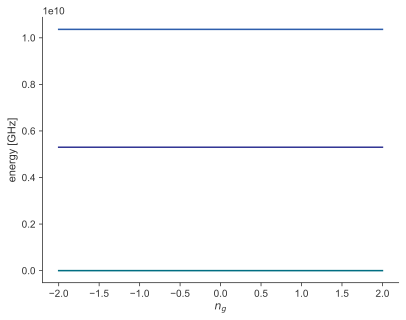

In [13]:
ng_list = np.linspace(-2, 2, 101)
e01_list = []
for ng in ng_list:
    e01_list.append(Transmon(EJ=Ej[0], EC=EC, ng=ng, ncut=31).E01())
e01_min = min(e01_list)
e01_max = max(e01_list)
delta_e01 = (e01_max - e01_min)/1e9
print("Energy dispersion is ", delta_e01, "GHz")
transmon.plot_evals_vs_paramvals('ng', ng_list, evals_count=3, subtract_ground=True)

In [14]:
corrected_rr_freq = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cir = Network([
        C(0,1,c_sigma- cqrs[i]), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r[i] - cqrs[i]), # resonator
        L(0,2,l_r[i]),
        C(1,2, cqrs[i]), # coupling capacitor
        R(0, 2, 1e6)
        ])
    # f,k,A,chi = 
    cir.f_k_A_chi(pretty_print=True, Lj = Ljs[i])
    ham = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = Ljs[i])
    ee = ham.eigenenergies()
    ee -= ee[0]
    corrected_rr_freq[i] = ee[2]


         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.22 GHz |       216 Hz |      215 MHz |
            1 |        7 GHz |      560 kHz |       186 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      215 MHz |              |
            1 |      400 kHz |       186 Hz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.32 GHz |       223 Hz |      215 MHz |
            1 |      7.1 GHz |      568 kHz |       186 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      215 MHz |              |
            1 |      400 kHz |       186 Hz |



 C:\Users\moret\AppData\Local\Temp\ipykernel_15672\664116265.py: 19

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.42 GHz |       229 Hz |      215 MHz |
            1 |      7.2 GHz |      576 kHz |       186 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      215 MHz |              |
            1 |      400 kHz |       186 Hz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.52 GHz |       235 Hz |      215 MHz |
            1 |      7.3 GHz |      584 kHz |       186 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      215 MHz |              |
            1 |      400 kHz |       186 Hz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.62 GHz |       242 Hz |      215 MHz |
            1 |      7.4 GHz |      592 kHz |       186 Hz |

Kerr coefficients (diagonal = Kerr, off-diag

In [15]:
cir = Network([
    C(0,1,c_sigma- cqrs[i]), # transmon
    J(0,1,'Lj'),
    C(0,2,c_r[i] - cqrs[i]), # resonator
    L(0,2,l_r[i]),
    C(1,2, cqrs[i]), # coupling capacitor
    ])

In [16]:
g = 2*np.pi*EC/ (e_charge) * (Ej/EC/2)**(1/4) * cqrs / (c_r) * np.sqrt(2*planck_h * rr_freq_target * (c_r))
delta = (rr_freq_target - transmon.E01()) * 2*np.pi

lamb_shift = 2*g**2 / delta / 2 / np.pi
g/2/np.pi

array([47299637.23281266, 47401005.13646412, 47499542.12485051,
       47595365.02485914, 47688585.05999085, 47779306.4290179 ])

In [17]:
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0)/ 2/ pi / np.sqrt(2)
    return abs(k - kappa_target)

In [18]:
cks = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15
    

In [19]:
cks

array([7.11702644e-15, 6.96719741e-15, 6.82255263e-15, 6.68284440e-15,
       6.54784002e-15, 6.41732071e-15])

In [20]:
# I think this is the right one. Check with eigenmode!
digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_lengths = v_ph / rr_freq_target / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_lengths*c_l - cqr_to_ground(cqrs) - ck_to_ground(cks))*
                                (unloaded_wg_lengths*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_lengths*c_l - cqr_to_ground(cqrs) - ck_to_ground(cks))*
                                (unloaded_wg_lengths*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded -= cqrs
c_r_loaded -= cks
resonator_waveguide_lengths = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
resonator_waveguide_lengths

array([0.00832947, 0.00821251, 0.00809875, 0.00798807, 0.00788035,
       0.00777549])

In [21]:
coupler_width_given_c_qr, c_sigma_given_coupler_width = clockmon_coupling_libraries()
ck_given_coupling = get_ck()
for i in range(nb_qubits):
    coupler_width = coupler_width_given_c_qr(cqrs[i])
    finger_control = ck_given_coupling(cks[i])
    print(f"Coupler width for qubit {i}: {coupler_width:.5} um")
    print(f"Finger control for qubit {i}: {finger_control:.5}")
    print(f"Resonator length for qubit {i}: {resonator_waveguide_lengths[i]*1e6:.5} um")

Coupler width for qubit 0: 53.178 um
Finger control for qubit 0: 1.9811
Resonator length for qubit 0: 8329.5 um
Coupler width for qubit 1: 51.081 um
Finger control for qubit 1: 1.9643
Resonator length for qubit 1: 8212.5 um
Coupler width for qubit 2: 49.053 um
Finger control for qubit 2: 1.9476
Resonator length for qubit 2: 8098.7 um
Coupler width for qubit 3: 47.093 um
Finger control for qubit 3: 1.9311
Resonator length for qubit 3: 7988.1 um
Coupler width for qubit 4: 45.207 um
Finger control for qubit 4: 1.9151
Resonator length for qubit 4: 7880.4 um
Coupler width for qubit 5: 43.389 um
Finger control for qubit 5: 1.8992
Resonator length for qubit 5: 7775.5 um


In [38]:
fl_traits = pd.read_csv("single_doublepads_00.csv").values[0][1:]
tee_size = pd.read_csv("single_doublepads_00.csv").values[1][1:]
res_length = pd.read_csv("single_doublepads_00.csv").values[2][1:]

tee_size = tee_size[pd.isna(tee_size) == 0]
res_length =res_length[pd.isna(res_length) == 0]

transmission_line_tee_points = [
    float(fl_traits[0]), # From input launcher to feedline capacitor
    fl_traits[1] + (a + 2*b)/2, # From feedline capacitor to tee0
    fl_traits[2] + (a + 2*b), # From tee0 to tee1
    fl_traits[3] + (a + 2*b), # From tee1 to tee2
    fl_traits[4] + (a + 2*b), # From tee2 to tee3
    fl_traits[5] + (a + 2*b), # From tee3, to tee4 
    fl_traits[6] + (a + 2*b), # From tee4, to tee5
    fl_traits[7] + (a + 2*b), # From tee5, to tee6 (from tee6 we split into output launcher and feedline resonator tail)
    fl_traits[8] + (a + 2*b)/2, # From tee6 to output launcher
    fl_traits[9] + 30, # from tee6 to ground (feedline resonator tail endpoint)
]

feedline_res_length = fl_traits[1] + (a + 2*b)/2 + \
    fl_traits[2] + (a + 2*b) + \
    fl_traits[3] + (a + 2*b) + \
    fl_traits[4] + (a + 2*b) + \
    fl_traits[5] + (a + 2*b) + \
    fl_traits[6] + (a + 2*b) + \
    fl_traits[7] + (a + 2*b) + \
    fl_traits[8] + 30 + fl_traits[9] + (a + 2*b)/2
qb_pos_0 = fl_traits[1] + (a + 2*b)/2
qb_pos_1 = qb_pos_0 + fl_traits[2] + (a + 2*b)
qb_pos_2 = qb_pos_1 + fl_traits[3] + (a + 2*b)
qb_pos_3 = qb_pos_2 + fl_traits[4] + (a + 2*b)
qb_pos_4 = qb_pos_3 + fl_traits[5] + (a + 2*b)
qb_pos_5 = qb_pos_4 + fl_traits[6] + (a + 2*b)

In [40]:
def resonance_profile(x, total_length, order):
    return (1 + np.cos(2*np.pi*x*(order + 1/2)/total_length))/2

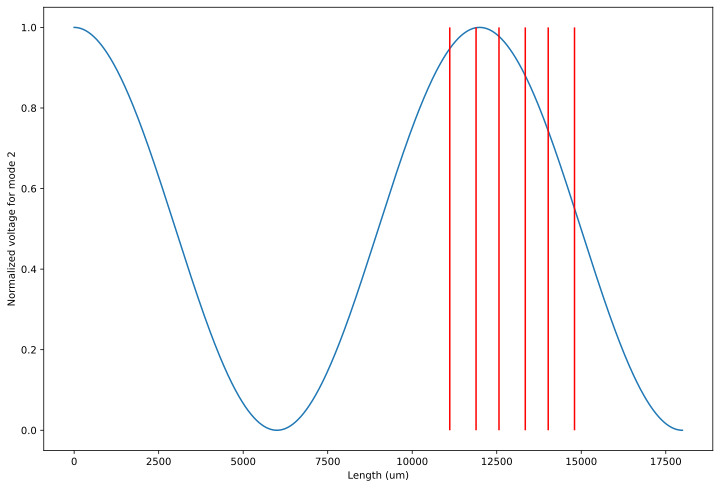

In [42]:
xdata = np.linspace(0, feedline_res_length, 1001)
plt.figure(figsize=(12, 8))
plt.ylabel("Normalized voltage for mode 2")
plt.xlabel("Length (um)")

plt.plot(xdata, resonance_profile(xdata, feedline_res_length, order = 1))
plt.vlines([qb_pos_0, qb_pos_1, qb_pos_2, qb_pos_3, qb_pos_4, qb_pos_5], ymin = 0, ymax = 1, colors="r")
corrections_to_ck = resonance_profile(np.array([qb_pos_0, qb_pos_1, qb_pos_2, qb_pos_3, qb_pos_4, qb_pos_5]), feedline_res_length, order = 1)

In [43]:
def minimize_for_ck(x, resonator_frequency, correction_to_ck):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0)/ 2/ pi / np.sqrt(2)
    k = k*correction_to_ck
    return abs(k - kappa_target)

cks = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i], corrections_to_ck[i]))[0]*1e-15
cks = np.abs(cks)

In [44]:
cks

array([7.31211018e-15, 6.96987879e-15, 6.89986791e-15, 7.12360379e-15,
       7.59432652e-15, 8.65041745e-15])

In [45]:
resonator_capacitance = c_r - cks -  cqrs
cfl = 5e-14
options = {
    "qubit_c": np.array([c_sigma]*6),
    "qubit_l": Ljs,
    "readout_resonator_c": resonator_capacitance,
    "readout_resonator_l": l_r,
    "ck": cks,
    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "cfl": cfl,
    "frequency": [0.1, 8.5],
    "n_points": 3001,
    "type": "feedline_resonator",
    "a": a,
    "b": b,
    "ep_r": ep_r
}

2-Port Network: '',  0.1-8.5 GHz, 3001 pts, z0=[50.+0.j 50.+0.j]


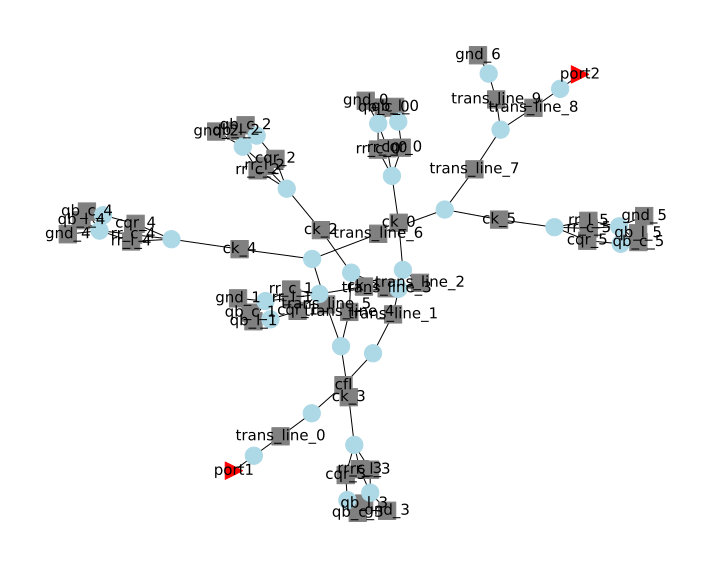

In [46]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

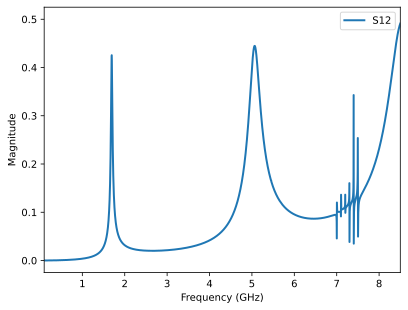

In [47]:
ntw.plot_s_mag(m=0, n=1, lw=2)
import matplotlib.pyplot as plt
# plt.vlines(x = 1/np.sqrt(c_r*l_r) / 2 / np.pi, ymin = 0, ymax = 1, colors="red")

# plt.vlines(x = 1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi +lamb_shift[-1], ymin = 0, ymax = 1, colors="red")
plt.hlines(y = 0.5, xmin =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi - kappa_target/2 +lamb_shift[-1],
           xmax =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi  + kappa_target/2 +lamb_shift[-1], colors="green")

# # plt.vlines(x = 1/np.sqrt(c_r*l_r) / 2 / np.pi +lamb_shift, ymin = 0, ymax = 1, colors="red")
# plt.hlines(y = 0.5, xmin =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi - kappa_target/2 +lamb_shift[-1],
#            xmax =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi  + kappa_target/2 +lamb_shift[-1], colors="green")

In [55]:
# T1 Purcell:
delta = rr_freq_target - target_parameters["qubit_frequency"]
k_purcell = kappa_target* (g/2/np.pi/delta)**2
T1_purcell = 1/(2*np.pi*k_purcell)
print(T1_purcell)

[0.00035569 0.00035417 0.0003527  0.00035129 0.00034991 0.00034859]


In [56]:
# T1 Purcell - adapting the formula to the filter presence (eq. 178 of https://doi.org/10.1063/1.5089550):

purcell_Q = 6 # corresponding to a kappa of 1 GHz
delta = rr_freq_target - target_parameters["qubit_frequency"]
actual_kappa_readout_resonator = resonator_kappa(rr_freq_target, cks, Z0)/ 2/ pi / np.sqrt(2)
k_purcell_ = actual_kappa_readout_resonator* (g/2/np.pi/delta)**2

k_purcell_ = kappa_target* (g/2/np.pi/delta)**2
T1_purcell = 1/(2*np.pi*k_purcell_) / (qubit_freq_target/ 2 / purcell_Q / delta)
print(T1_purcell)

[0.00170732 0.00166669 0.00162787 0.00159073 0.00155517 0.0015211 ]


In [57]:
# For when we'll need chargelines/fluxlines: https://quantumcomputing.stackexchange.com/questions/33136/how-to-estimate-the-losses-of-a-transmon-qubit-to-its-flux-bias-line

In [59]:
finger_control_feedline = ck_given_coupling(cfl)
print(f"Finger control probeline capacitor: {finger_control_feedline:.5}")

Finger control probeline capacitor: 4.2527


In [57]:
df = pd.DataFrame(columns=['resonator 01','qubit 01', 'anharmonicity','chi/2pi','g/2pi', 'C_sigma', 'Lj', 'Ic', 'T1 Purcell'], index=['qb0','qb1','qb2', 'qb3', 'qb4', 'qb5'])
df['resonator 01'] = rr_freq_target
df['qubit 01'] = qubit_freq_target
df['anharmonicity'] = anharmonicities
df['chi/2pi'] = [target_parameters["chi"]]*6
df['g/2pi'] = g/2/np.pi
df['C_sigma'] = [c_sigma]*6
df["Lj"] = Ljs
df['Ic'] = Ic
df['T1 Purcell'] = T1_purcell

In [58]:
df

,resonator 01,qubit 01,anharmonicity,chi/2pi,g/2pi,C_sigma,Lj,Ic,T1 Purcell
qb0,7.000000e+09,5.000000e+09,-2.400522e+08,400000.0,4.729964e+07,9.000000e-14,1.030719e-08,3.192976e-08,0.001707
qb1,7.100000e+09,5.100000e+09,-2.394663e+08,400000.0,4.740101e+07,9.000000e-14,9.924430e-09,3.316120e-08,0.001667
qb2,7.200000e+09,5.200000e+09,-2.389081e+08,400000.0,4.749954e+07,9.000000e-14,9.562578e-09,3.441603e-08,0.001628
qb3,7.300000e+09,5.300000e+09,-2.383754e+08,400000.0,4.759537e+07,9.000000e-14,9.220137e-09,3.569426e-08,0.001591
qb4,7.400000e+09,5.400000e+09,-2.378667e+08,400000.0,4.768859e+07,9.000000e-14,8.895746e-09,3.699588e-08,0.001555
qb5,7.500000e+09,5.500000e+09,-2.373802e+08,400000.0,4.777931e+07,9.000000e-14,8.588159e-09,3.832090e-08,0.001521
